In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../input/mall-customers-data-set/Mall_Customers.csv")
df.rename(columns = { 
    'Annual Income (k$)': 'Annual Income', 
    'Spending Score (1-100)': 'Spending Score'
}, inplace = True)
df.head()

,CustomerID,Genre,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
data = df[['Genre', 'Age', 'Annual Income', 'Spending Score']]
data = pd.get_dummies(data, columns= ['Genre'])
data['Cluster'] = 0
data.head()

,Age,Annual Income,Spending Score,Genre_Female,Genre_Male,Cluster
0,19,15,39,0,1,0
1,21,15,81,0,1,0
2,20,16,6,1,0,0
3,23,16,77,1,0,0
4,31,17,40,1,0,0


In [4]:
def Euclidean_distance(point1, point2):
    distance = 0
    for col in data.columns:
        if col!='Cluster' and col!='State':
            distance += np.square(point1[col]-point2[col])
    return np.sqrt(distance)

In [5]:
def Core_Test(idx, epsilon):
    points = []
    for i in range(data.shape[0]):
        dist = Euclidean_distance(data.iloc[idx], data.iloc[i])
        if dist<=epsilon and dist>0:
            points.append(i)
    return points

In [6]:
def End_Condition():
    for i in range(data.shape[0]):
        if data.iloc[i]['State']=='-':
            return True
    return False

In [7]:
np.random.seed(10)

def DB_Scan(epsilon, minPoints):
    data['State'] = '-'
    cluster_value = 1
    while End_Condition():
        index = np.random.randint(0, data.shape[0])
        if data.iloc[index]['State']=='-':
            point_list =  Core_Test(index, epsilon)
            if (len(point_list)+1)<minPoints:
                data['State'][index] = 'Outlier'
                continue
            data['Cluster'][index] = cluster_value
            data['State'][index] = 'CorePoint'
            print('Cluster:', cluster_value, end=" ")
            while len(point_list)>0:
                point = point_list.pop(0)
                if data.iloc[point]['State']=='-':
                    neigbour_points = Core_Test(point, epsilon)
                    if (len(neigbour_points)+1)>=minPoints:
                        data['Cluster'][point] = cluster_value
                        data['State'][point] = 'CorePoint'
                        for neigbour in neigbour_points:
                            if data.iloc[neigbour]['State']=='-' or data.iloc[neigbour]['State']=='Outlier':
                                point_list.append(neigbour)
                    else:
                        data['Cluster'][point] = cluster_value
                        data['State'][point] = 'BorderPoint'
                elif data.iloc[point]['State']=='Outlier':
                    neigbour_points = Core_Test(point, epsilon)
                    for neigbour in neigbour_points:
                        if data.iloc[neigbour]['State']=='CorePoint':
                            data['Cluster'][point] = cluster_value
                            data['State'][point] = 'BorderPoint'
#                             print('*', end=" ")                    
            print('Total Points: ', data[data['Cluster']==cluster_value].shape[0])
            cluster_value+=1

In [8]:
DB_Scan(15, 7)

Cluster: 1 Total Points:  113
Cluster: 2 Total Points:  34
Cluster: 3 Total Points:  27
Cluster: 4 Total Points:  8


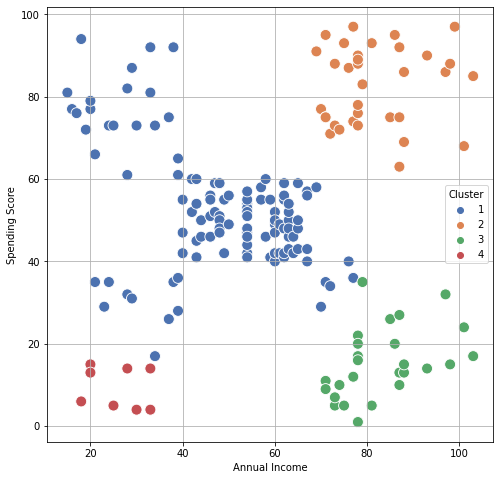

In [9]:
clusters = data[data['Cluster']!=0]
plt.figure(figsize=(8, 8))
sns.scatterplot(data=clusters, x='Annual Income', y='Spending Score', hue='Cluster', palette="deep", s=120)
plt.grid(True)
plt.show()

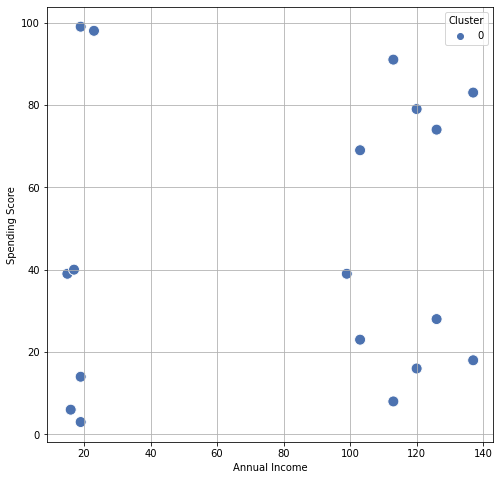

In [10]:
out = data[data['Cluster']==0]
plt.figure(figsize=(8,8))
sns.scatterplot(data=out, x='Annual Income', y='Spending Score', hue='Cluster', palette="deep", s=120)
plt.grid(True)
plt.show()

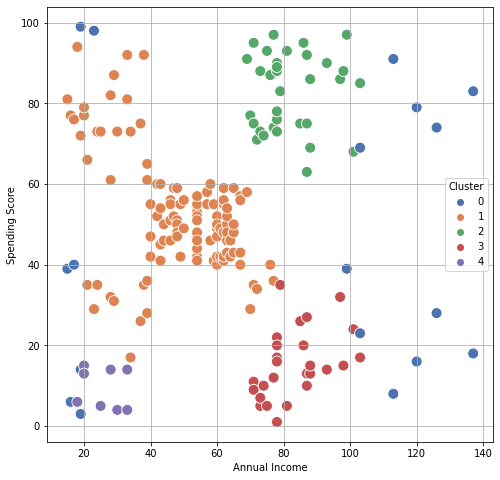

In [11]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=data, x='Annual Income', y='Spending Score', hue='Cluster', palette="deep", s=120)
plt.grid(True)
plt.show()

# Using Sklearn DBScan

In [12]:
import copy
from sklearn.cluster import DBSCAN

In [13]:
sample = pd.read_csv("../input/mall-customers-data-set/Mall_Customers.csv")
sample.rename(columns = { 
    'Annual Income (k$)': 'Annual Income', 
    'Spending Score (1-100)': 'Spending Score'
}, inplace = True)
sample = sample[['Genre', 'Age', 'Annual Income', 'Spending Score']]
sample = pd.get_dummies(sample, columns= ['Genre'])
sample.head()

,Age,Annual Income,Spending Score,Genre_Female,Genre_Male
0,19,15,39,0,1
1,21,15,81,0,1
2,20,16,6,1,0
3,23,16,77,1,0
4,31,17,40,1,0


In [14]:
clustering = DBSCAN(eps=15, min_samples=7).fit(sample)

In [15]:
sample['Cluster'] = clustering.labels_

In [16]:
sample.groupby('Cluster')['Cluster'].count()

Cluster
-1     18
 0    113
 1      8
 2     34
 3     27
Name: Cluster, dtype: int64

In [17]:
sample.head()

,Age,Annual Income,Spending Score,Genre_Female,Genre_Male,Cluster
0,19,15,39,0,1,-1
1,21,15,81,0,1,0
2,20,16,6,1,0,-1
3,23,16,77,1,0,0
4,31,17,40,1,0,-1


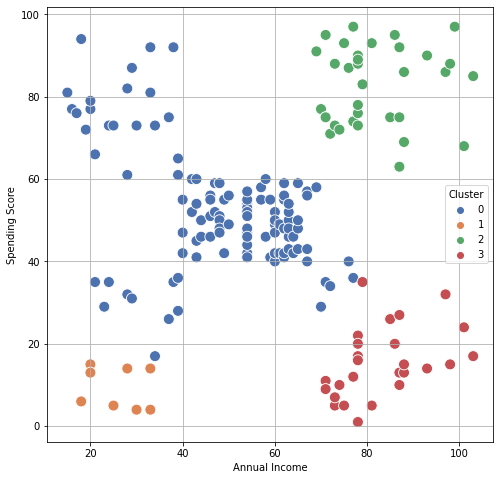

In [18]:
rex = sample[sample['Cluster']!=-1]
plt.figure(figsize=(8, 8))
sns.scatterplot(data=rex, x='Annual Income', y='Spending Score', hue='Cluster', palette="deep", s=120)
plt.grid(True)
plt.show()